# Maxwell solver with leap-frog scheme

We implement a leap-frog scheme for the Maxwell equations in vacuum

$$
\begin{align}
    - \frac{\partial \mathbf{E}}{\partial t} + \nabla \times \mathbf{B} & = 0 \\[3mm]
    \frac{\partial \mathbf{B}}{\partial t} + \nabla \times \mathbf{E} & = 0
\end{align}
$$

See the [fourth exercise sheet](http://www-m16.ma.tum.de/foswiki/pub/M16/Allgemeines/CompPlasmaPhys22/exercise04.pdf) for details.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# a function to update the electric field vector E
def update_E_vec(dt, h, N, E_vec, B_vec):
    """
    Updates the electric field with time-step size dt

    Parameters:
        dt    : time-step size
        h     : array of grid-spacings in all 3 directions
        N     : array with numbers of grid points in all 3 directions
        E_vec : array of electric field vector
        B_vec : array of magnetic field vector
    """
    E_vec_new = np.zeros( np.shape(E_vec), dtype=float)

    delta_n = dt / h; # a vector
    
    for i in range(N[0]):
        for j in range(N[1]):
            for k in range(N[2]):
                E_vec_new[0,i,j,k] = E_vec[0,i,j,k] + (delta_n[1] * (B_vec[2,i,j,k] - B_vec[2,i,(j-1),k]) - delta_n[2] * (B_vec[1,i,j,k] - B_vec[1,i,j,(k-1)]))
                E_vec_new[1,i,j,k] = E_vec[1,i,j,k] + (delta_n[2] * (B_vec[0,i,j,k] - B_vec[0,i,j,(k-1)]) - delta_n[0] * (B_vec[2,i,j,k] - B_vec[2,(i-1),j,k]))
                E_vec_new[2,i,j,k] = E_vec[2,i,j,k] + (delta_n[0] * (B_vec[1,i,j,k] - B_vec[1,(i-1),j,k]) - delta_n[1] * (B_vec[0,i,j,k] - B_vec[0,i,(j-1),k]))
    
    return E_vec_new


# a function to update the magnetic field vector E
def update_B_vec(dt, h, N, E_vec, B_vec):
    """
    Updates the magnetic field with time-step size dt

    Parameters:
        dt    : time-step size
        h     : array of grid-spacings in all 3 directions
        N     : array with numbers of grid points in all 3 directions
        E_vec : array of electric field vector
        B_vec : array of magnetic field vector
    """
    B_vec_new = np.zeros( np.shape(B_vec), dtype=float)
    
    delta_n = dt / h;

    for i in range(N[0]):
        for j in range(N[1]):
            for k in range(N[2]):
                B_vec_new[0,i,j,k] = B_vec[0,i,j,k] - (delta_n[1] * (E_vec[2,i,j,k] - E_vec[2,i,(j-1),k]) - delta_n[2] * (E_vec[1,i,j,k] - E_vec[1,i,j,(k-1)]))
                B_vec_new[1,i,j,k] = B_vec[1,i,j,k] - (delta_n[2] * (E_vec[0,i,j,k] - E_vec[0,i,j,(k-1)]) - delta_n[0] * (E_vec[2,i,j,k] - E_vec[2,(i-1),j,k]))
                B_vec_new[2,i,j,k] = B_vec[2,i,j,k] - (delta_n[0] * (E_vec[1,i,j,k] - E_vec[1,(i-1),j,k]) - delta_n[1] * (E_vec[0,i,j,k] - E_vec[0,i,(j-1),k]))
    
    return B_vec_new

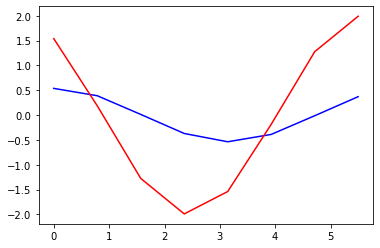

In [34]:
# Set parameters for time iteration

dt          = 0.01
N_timesteps = 200
t_end       = dt * N_timesteps

# Set parameters for space
N = [8, 8, 8]
a = 0
b = 2 * np.pi



# Implement analytical test solution
Ex_ana = lambda t,x,y,z : np.cos(x + y + z - np.sqrt(3 * t))
Ey_ana = lambda t,x,y,z : -2 * np.cos(x + y + z - np.sqrt(3 * t))
Ez_ana = lambda t,x,y,z : np.cos(x + y + z - np.sqrt(3 * t))

Bx_ana = lambda t,x,y,z : np.sqrt(3) * np.cos(x + y + z - np.sqrt(3 * t))
By_ana = lambda t,x,y,z : 0
Bz_ana = lambda t,x,y,z : - np.sqrt(3) * np.cos(x + y + z - np.sqrt(3 * t))


def eval_E_ana(t, Omega, N):
    E_ana_temp = np.empty([3, N[0], N[1], N[2]])

    for i in range(N[0]):
        for j in range(N[1]):
            for k in range(N[2]):
                E_ana_temp[0,i,j,k] = Ex_ana(t, Omega[0][i], Omega[1][j], Omega[2][k])
                E_ana_temp[1,i,j,k] = Ey_ana(t, Omega[0][i], Omega[1][j], Omega[2][k])
                E_ana_temp[2,i,j,k] = Ez_ana(t, Omega[0][i], Omega[1][j], Omega[2][k])
    
    return E_ana_temp


def eval_B_ana(t, Omega, N):
    B_ana_temp = np.empty([3, N[0], N[1], N[2]])

    for i in range(N[0]):
        for j in range(N[1]):
            for k in range(N[2]):
                B_ana_temp[0,i,j,k] = Bx_ana(t, Omega[0][i], Omega[1][j], Omega[2][k])
                B_ana_temp[1,i,j,k] = By_ana(t, Omega[0][i], Omega[1][j], Omega[2][k])
                B_ana_temp[2,i,j,k] = Bz_ana(t, Omega[0][i], Omega[1][j], Omega[2][k])
    
    return B_ana_temp


# Set up the grid
Omega = [None]*3
h     = np.empty(3, dtype=float)
for i in range(3):
    Omega[i] = np.linspace(a, b, N[i]+1)[:-1]
    h[i]     = Omega[i][1] - Omega[i][0]


# Create initial conditions arrays
E0   = eval_E_ana(0, Omega, N)
B0   = eval_B_ana(0, Omega, N)

# Fill arrays for initial conditions with analytical solution (already filled)

# for i in range(N[0]):
#     for j in range(N[1]):
#         for k in range(N[2]):
#             E0[0,i,j,k] = 
#             E0[1,i,j,k] = 
#             E0[2,i,j,k] = 

#             B0[0,i,j,k] = 
#             B0[1,i,j,k] = 
#             B0[2,i,j,k] = 
            
# Set starting value to initial condition
E_vec = E0.copy()
B_vec = B0.copy()

# do the time-iteration
for k in range(N_timesteps):
    E_vec = update_E_vec(dt, h, N, E_vec, B_vec)
    B_vec = update_B_vec(dt, h, N, E_vec, B_vec)

# Compare with the analytical solution
E_ana = eval_E_ana(t_end, Omega, N)
B_ana = eval_B_ana(t_end + dt/2, Omega, N)

plt.plot(Omega[1], E_vec[1,4,:,4], label='approximation', color = 'blue')
plt.plot(Omega[1], E_ana[1,4,:,4], label='analytical', color = 'red')
#plt.xlabel(  )
#plt.ylabel(  )
#plt.legend(  )
#plt.title(  )